In [1]:
import random
import os
import time
import gc 
import math
from collections import OrderedDict
from typing import Callable, Dict, List, Optional, Tuple
from pathlib import Path

from matplotlib import pyplot as plt
from IPython import display
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Subset, RandomSampler
import numpy as np
from scipy.optimize import linear_sum_assignment
import torchvision
from torchvision.ops import box_convert, generalized_box_iou
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelP6P7, ExtraFPNBlock
from torchvision.ops.misc import Conv2dNormActivation
import timm
from timm.layers import resample_abs_pos_embed 
from tqdm.auto import tqdm
from pprint import pformat
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import rasterio

from dl_toolbox.transforms import NormalizeBB
from dl_toolbox.utils import list_of_dicts_to_dict_of_lists
from dl_toolbox.utils import label, merge_labels_boxes


/d/pfournie/dl_toolbox/venv38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model

In [2]:
class Scale(nn.Module):

    def __init__(self, init_value=1.0):
        super(Scale, self).__init__()
        self.scale = nn.Parameter(torch.FloatTensor([init_value]))

    def forward(self, x):
        return x * self.scale


class Head(nn.Module):

    def __init__(self, in_channels, n_classes, n_share_convs=4, n_feat_levels=5):
        super().__init__()
        
        tower = []
        for _ in range(n_share_convs):
            tower.append(
                nn.Conv2d(in_channels,
                          in_channels,
                          kernel_size=3,
                          stride=1,
                          padding=1,
                          bias=True))
            tower.append(nn.GroupNorm(32, in_channels))
            tower.append(nn.ReLU())
        self.shared_layers = nn.Sequential(*tower)

        self.cls_logits = nn.Conv2d(in_channels,
                                    n_classes,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)
        self.bbox_pred = nn.Conv2d(in_channels,
                                   4,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1)
        self.ctrness = nn.Conv2d(in_channels,
                                 1,
                                 kernel_size=3,
                                 stride=1,
                                 padding=1)

        self.scales = nn.ModuleList([Scale(init_value=1.0) for _ in range(n_feat_levels)])

    def forward(self, x):
        cls_logits = []
        bbox_preds = []
        cness_preds = []
        for l, features in enumerate(x):
            features = self.shared_layers(features)
            cls_logits.append(self.cls_logits(features).flatten(-2))
            cness_preds.append(self.ctrness(features).flatten(-2))
            reg = self.bbox_pred(features)
            reg = self.scales[l](reg)
            bbox_preds.append(nn.functional.relu(reg).flatten(-2))
        all_logits = torch.cat(cls_logits, dim=-1).permute(0,2,1) # BxNumAnchorsxC
        all_box_regs = torch.cat(bbox_preds, dim=-1).permute(0,2,1) # BxNumAnchorsx4
        all_cness = torch.cat(cness_preds, dim=-1).permute(0,2,1) # BxNumAnchorsx1
        return all_logits, all_box_regs, all_cness

class LayerNorm2d(nn.LayerNorm):
    """ LayerNorm for channels of '2D' spatial NCHW tensors """
    def __init__(self, num_channels, eps=1e-6, affine=True):
        super().__init__(num_channels, eps=eps, elementwise_affine=affine)

    def forward(self, x):
        return nn.functional.layer_norm(
            x.permute(0, 2, 3, 1), self.normalized_shape, self.weight, self.bias, self.eps).permute(0, 3, 1, 2)

class SimpleFeaturePyramidNetwork(nn.Module):
    """
    Module that adds a Simple FPN from on top of a set of feature maps. This is based on
    `"Exploring Plain Vision Transformer Backbones for Object Detection" <https://arxiv.org/abs/2203.16527>`_.

    Unlike regular FPN, Simple FPN expects a single feature map,
    on which the Simple FPN will be added.

    Args:
        in_channels (int): number of channels for the input feature map that
            is passed to the module
        out_channels (int): number of channels of the Simple FPN representation
        extra_blocks (ExtraFPNBlock or None): if provided, extra operations will
            be performed. It is expected to take the fpn features, the original
            features and the names of the original features as input, and returns
            a new list of feature maps and their corresponding names
        norm_layer (callable, optional): Module specifying the normalization layer to use. Default: LayerNorm

    Examples::
    
        >>> vitdet = ViTDet(256, 10)
        >>> x = torch.rand(2, 3, 224, 224)
        >>> feat_dict = vitdet.forward_feat(x)
        >>> features = list(feat_dict.values())
        >>> print(f'{[f.shape for f in features] = }')
        >>> box_cls, box_regression, centerness = vitdet.head(features)
        >>> print(f'{box_cls.shape = }')
        >>> assert sum([f.shape[2]*f.shape[3] for f in features])==box_cls.shape[1]

        DOES NOT WORK BELOW
        >>> m = torchvision.ops.SimpleFeaturePyramidNetwork(10, 5)
        >>> # get some dummy data
        >>> x = torch.rand(1, 10, 64, 64)
        >>> # compute the Simple FPN on top of x
        >>> output = m(x)
        >>> print([(k, v.shape) for k, v in output.items()])
        >>> # returns
        >>>   [('feat0', torch.Size([1, 5, 64, 64])),
        >>>    ('feat2', torch.Size([1, 5, 16, 16])),
        >>>    ('feat3', torch.Size([1, 5, 8, 8]))]

    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ):
        super().__init__()
        self.blocks = nn.ModuleList()
        for block_index in range(0,4):
            layers = []
            current_in_channels = in_channels
            if block_index == 0:
                layers.extend([
                    nn.ConvTranspose2d(
                        in_channels,
                        in_channels // 2,
                        kernel_size=2,
                        stride=2,
                    ),
                    norm_layer(in_channels // 2),
                    nn.GELU(),
                    nn.ConvTranspose2d(
                        in_channels // 2,
                        in_channels // 4,
                        kernel_size=2,
                        stride=2,
                    ),
                ])
                current_in_channels = in_channels // 4
            elif block_index == 1:
                layers.append(
                    nn.ConvTranspose2d(
                        in_channels,
                        in_channels // 2,
                        kernel_size=2,
                        stride=2,
                    ),
                )
                current_in_channels = in_channels // 2
            elif block_index == 2:
                # nothing to do for this scale
                pass
            elif block_index == 3:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            layers.extend([
                Conv2dNormActivation(
                    current_in_channels,
                    out_channels,
                    kernel_size=1,
                    padding=0,
                    norm_layer=norm_layer,
                    activation_layer=None
                ),
                Conv2dNormActivation(
                    out_channels,
                    out_channels,
                    kernel_size=3,
                    norm_layer=norm_layer,
                    activation_layer=None
                )
            ])
            self.blocks.append(nn.Sequential(*layers))

        if extra_blocks is not None:
            if not isinstance(extra_blocks, ExtraFPNBlock):
                raise TypeError(f"extra_blocks should be of type ExtraFPNBlock not {type(extra_blocks)}")
        self.extra_blocks = extra_blocks

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        """
        Computes the Simple FPN for a feature map.

        Args:
            x (Tensor): input feature map.

        Returns:
            results (list[Tensor]): feature maps after FPN layers.
                They are ordered from highest resolution first.
        """
        results = [block(x) for block in self.blocks]
        names = [f"{i}" for i in range(len(self.blocks))]

        if self.extra_blocks is not None:
            results, names = self.extra_blocks(results, [x], names)

        # make it back an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)])

        return out
    
class ViTDet(nn.Module):
    
    def __init__(self, out_channels, num_classes):
        super(ViTDet, self).__init__()
        #self.backbone = timm.create_model('samvit_base_patch16.sa1b', pretrained=True)
        self.backbone = timm.create_model(
            'vit_tiny_patch16_224',
            pretrained=True,
            dynamic_img_size=True #Deals with inputs of other size than pretraining
        )
        self.sfpn = SimpleFeaturePyramidNetwork(
            in_channels=192,
            out_channels=out_channels,
            #extra_blocks=LastLevelP6P7(out_channels,out_channels),
            norm_layer=LayerNorm2d
        )
        self.head = Head(out_channels, num_classes, n_feat_levels=4) # 6=4+2extrablocks
        
    def forward_feat(self, x):
        intermediates = self.backbone.forward_intermediates(x, indices=1, norm=False, intermediates_only=True)
        features = self.sfpn(intermediates[0])
        return features
    
    def forward(self, x):
        feat_dict = self.forward_feat(x)
        features = list(feat_dict.values())
        box_cls, box_regression, centerness = self.head(features)
        return box_cls, box_regression, centerness

### Loss

In [3]:
class LossEvaluator(nn.Module):

    def __init__(self, num_classes):
        super(LossEvaluator, self).__init__()
        self.centerness_loss_func = nn.BCEWithLogitsLoss(reduction="sum")
        self.num_classes = num_classes
                
    def __call__(self, cls_logits, reg_preds, cness_preds, cls_tgts, reg_tgts):
        pos_inds_b, pos_inds_loc = torch.nonzero(cls_tgts > 0, as_tuple=True)
        num_pos = len(pos_inds_b)
        reg_preds = reg_preds[pos_inds_b, pos_inds_loc, :]
        reg_tgts = reg_tgts[pos_inds_b, pos_inds_loc, :]
        cness_preds = cness_preds[pos_inds_b, pos_inds_loc, :].squeeze(-1)
        cness_tgts = self._compute_centerness_targets(reg_tgts)
        cls_loss = self._get_cls_loss(cls_logits, cls_tgts, max(num_pos, 1.))
        #reg_loss, centerness_loss = 0,0
        #if num_pos > 0:
        reg_loss = self._get_reg_loss(
            reg_preds, reg_tgts, cness_tgts)
        centerness_loss = self._get_centerness_loss(
            cness_preds, cness_tgts, max(num_pos, 1.))
        losses = {}
        losses["cls_loss"] = cls_loss
        losses["reg_loss"] = reg_loss
        losses["centerness_loss"] = centerness_loss
        losses["combined_loss"] = cls_loss + reg_loss + centerness_loss
        return losses
    
    def _compute_centerness_targets(self, reg_tgts):
        """
        Args:
            reg_tgts: l, t, r, b values to regress, shape BxNumAx4
        Returns:
            A tensor of shape BxNumA giving how centered each anchor is for the bbox it must regress
        """
        if len(reg_tgts) == 0:
            return reg_tgts.new_zeros(len(reg_tgts))
        left_right = reg_tgts[..., [0, 2]]
        top_bottom = reg_tgts[..., [1, 3]]
        centerness = (left_right.min(dim=-1)[0] / left_right.max(dim=-1)[0]) * \
                    (top_bottom.min(dim=-1)[0] / top_bottom.max(dim=-1)[0])
        return torch.sqrt(centerness)

    def _get_cls_loss(self, cls_preds, cls_targets, num_pos_samples):
        """
        cls_targets takes values in 0...C, 0 only when there is no obj to be detected for the anchor
        """
        onehot = nn.functional.one_hot(cls_targets.long(), self.num_classes+1)[...,1:].float()
        cls_loss = torchvision.ops.sigmoid_focal_loss(cls_preds, onehot)
        return cls_loss.sum() / num_pos_samples

    def _get_reg_loss(self, reg_preds, reg_targets, centerness_targets):
        ltrb_preds = reg_preds.reshape(-1, 4)
        ltrb_tgts = reg_targets.reshape(-1, 4)
        xyxy_preds = torch.cat([-ltrb_preds[:,:2], ltrb_preds[:,2:]], dim=1) 
        xyxy_tgts = torch.cat([-ltrb_tgts[:,:2], ltrb_tgts[:,2:]], dim=1)
        reg_losses = torchvision.ops.distance_box_iou_loss(xyxy_preds, xyxy_tgts, reduction='none')
        sum_centerness_targets = centerness_targets.sum()
        reg_loss = (reg_losses * centerness_targets).sum() / (sum_centerness_targets+1e-8)
        return reg_loss

    def _get_centerness_loss(self, centerness_preds, centerness_targets,
                             num_pos_samples):
        centerness_loss = self.centerness_loss_func(centerness_preds,
                                                    centerness_targets)
        return centerness_loss / num_pos_samples

### Matching

In [4]:
INF = 100000000

def get_fm_anchors(h, w, s):
    """
    Args:
        h, w: height, width of the feat map
        s: stride of the featmap = size reduction factor relative to image
    Returns:
        Tensor NumAnchorsInFeatMap x 2, ordered by column 
        TODO: check why: DONE: it corresponds to how locs are computed in 
        https://github.com/tianzhi0549/FCOS/blob/master/fcos_core/modeling/rpn/fcos/fcos.py
        When flattening feat maps, we see first the line at H(=y) fixed and W(=x) moving
        
    """
    locs_x = [s / 2 + x * s for x in range(w)]
    locs_y = [s / 2 + y * s for y in range(h)]
    locs = [(x, y) for y in locs_y for x in locs_x] # order !
    return torch.tensor(locs)

def get_all_anchors_bb_sizes(fm_sizes, fm_strides, bb_sizes):
    """
    Args:
        fm_sizes: seq of feature_maps sizes
        fm_strides: seq of corresponding strides
        bb_sizes: seq of bbox sizes feature maps are associated with, len = len(fm) + 1
    Returns:
        anchors: list of num_featmaps elem, where each elem indicates the tensor of anchors of size Nx2 in the original image corresponding to each location in the feature map at this level
        anchors_bb_sizes: sizes of the bbox each anchor is authorized/supposed to detect
    """
    bb_sizes = [-1] + bb_sizes + [INF]
    anchors, anchors_bb_sizes = [], []
    for l, ((h,w), s) in enumerate(zip(fm_sizes, fm_strides)):
        fm_anchors = get_fm_anchors(h, w, s)
        sizes = torch.tensor([bb_sizes[l], bb_sizes[l+1]], dtype=torch.float32)
        sizes = sizes.repeat(len(fm_anchors)).view(len(fm_anchors), 2)
        anchors.append(fm_anchors)
        anchors_bb_sizes.append(sizes)
    return torch.cat(anchors, 0), torch.cat(anchors_bb_sizes, 0)

In [5]:
def calculate_reg_targets(anchors, bbox):
    """
    Args:
        anchors: Lx2, anchors coordinates
        bbox: tensor of bbox Tx4, format should be xywh
    Returns:
        reg_tgt: l,t,r,b values to regress for each pair (anchor, bbox)
        anchor_in_box: whether anchor is in bbox for each pair (anchor, bbox)
    """
    xs, ys = anchors[:, 0], anchors[:, 1] # L & L, x & y reversed ?? x means position on x-axis
    l = xs[:, None] - bbox[:, 0][None] # Lx1 - 1xT -> LxT
    t = ys[:, None] - bbox[:, 1][None]
    r = bbox[:, 2][None] + bbox[:, 0][None] - xs[:, None]
    b = bbox[:, 3][None] + bbox[:, 1][None] - ys[:, None]  
    #print(xs[0], ys[0], l[0], t[0], r[0], b[0])
    return torch.stack([l, t, r, b], dim=2) # LxTx4

def apply_distance_constraints(reg_targets, anchor_sizes):
    """
    Args:
        reg_targets: LxTx4
        anchor_bb_sizes: Lx2
    Returns:
        A LxT tensor where value at (anchor, bbox) is true if the max value to regress at this anchor for this bbox is inside the bounds associated to this anchor
        If other values to regress than the max are negatives, it is dealt with anchor_in_boxes.
    """
    max_reg_targets, _ = reg_targets.max(dim=2) # LxT
    min_reg_targets, _ = reg_targets.min(dim=2) # LxT
    dist_constraints = torch.stack([
        min_reg_targets > 0,
        max_reg_targets >= anchor_sizes[:, None, 0],
        max_reg_targets <= anchor_sizes[:, None, 1]
    ])
    return torch.all(dist_constraints, dim=0)

def anchor_bbox_area(bbox, anchors, fits_to_feature_level):
    """
    Args: bbox is XYWH
    Returns: 
        Tensor LxT where value at (anchor, bbox) is the area of bbox if anchor is in bbox and anchor is associated with bbox of that size
        Else INF.
    """
    #bbox_areas = _calc_bbox_area(bbox_targets) # T
    bbox_areas = bbox[:, 2] * bbox[:, 3] # T
    # area of each target bbox repeated for each loc with inf where the the loc is not 
    # in the target bbox or if the loc is not at the right level for this bbox size
    anchor_bbox_area = bbox_areas[None].repeat(len(anchors), 1) # LxT
    anchor_bbox_area[~fits_to_feature_level] = INF
    return anchor_bbox_area

def associate_targets_to_anchors(targets_batch, anchors, anchors_bb_sizes):
    """
    Associate one target cls/bbox to regress ONLY to each anchor: among the bboxes that contain the anchor and have the right size, pick that of min area.
    If no tgt exists for an anchor, the tgt class is 0.
    inputs:
        targets_batch: list of dict of tv_tensors {'labels':, 'boxes':}; boxes should be in XYWH format
        anchors: 
        anchor_bb_sizes:
    outputs:
        all class targets: BxNumAnchors
        all bbox targets: BxNumAnchorsx4
    """
    all_reg_targets, all_cls_targets = [], []
    for targets in targets_batch:
        bbox_targets = targets['boxes'] # Tx4, format XYWH
        cls_targets = targets['labels'] # T
        reg_targets = calculate_reg_targets(
            anchors, bbox_targets) # LxTx4, LxT
        fits_to_feature_level = apply_distance_constraints(
            reg_targets, anchors_bb_sizes) # LxT
        locations_to_gt_area = anchor_bbox_area(
            bbox_targets, anchors, fits_to_feature_level)
        # Core of the anchor/target association
        if cls_targets.shape[0]>0:
            loc_min_area, loc_min_idxs = locations_to_gt_area.min(dim=1) #L,idx in [0,T-1],T must be>0
            reg_targets = reg_targets[range(len(anchors)), loc_min_idxs] # Lx4
            cls_targets = cls_targets[loc_min_idxs] # L
            cls_targets[loc_min_area == INF] = 0 # 0 is no-obj category
        else:
            cls_targets = cls_targets.new_zeros((len(anchors),))
            reg_targets = reg_targets.new_zeros((len(anchors),4))
        all_cls_targets.append(cls_targets)
        all_reg_targets.append(reg_targets)
    # BxL & BxLx4
    return torch.stack(all_cls_targets), torch.stack(all_reg_targets)

### Post-processing predictions to boxes

In [6]:
pre_nms_thresh=0.3
pre_nms_top_n=100000
nms_thresh=0.45
fpn_post_nms_top_n=50
min_size=0

def post_process(logits, ltrb, cness, input_size):
    probas = logits.sigmoid() # LxC
    high_probas = probas > pre_nms_thresh # LxC
    # Indices on L and C axis of high prob pairs anchor/class
    high_prob_anchors_idx, high_prob_cls = high_probas.nonzero(as_tuple=True) # dim l <= L*C
    high_prob_cls += 1 # 0 is for no object
    high_prob_ltrb = ltrb[high_prob_anchors_idx] # lx4
    high_prob_anchors = anchors[high_prob_anchors_idx] # lx2
    # Tensor shape l with values from logits*cness such that logits > pre_nms_thresh 
    cness_modulated_probas = probas * cness.sigmoid() # LxC
    high_prob_scores = cness_modulated_probas[high_probas] # l
    # si l est trop longue
    if high_probas.sum().item() > pre_nms_top_n:
        # Filter the pre_nms_top_n most probable pairs 
        high_prob_scores, top_k_indices = high_prob_scores.topk(
            pre_nms_top_n, sorted=False) 
        high_prob_cls = high_prob_cls[top_k_indices]
        high_prob_ltrb = high_prob_ltrb[top_k_indices]
        high_prob_anchors = high_prob_anchors[top_k_indices]

    # Rewrites bbox (x0,y0,x1,y1) from reg targets (l,t,r,b) following eq (1) in paper
    high_prob_boxes = torch.stack([
        high_prob_anchors[:, 0] - high_prob_ltrb[:, 0],
        high_prob_anchors[:, 1] - high_prob_ltrb[:, 1],
        high_prob_anchors[:, 0] + high_prob_ltrb[:, 2],
        high_prob_anchors[:, 1] + high_prob_ltrb[:, 3],
    ], dim=1)

    high_prob_boxes = torchvision.ops.clip_boxes_to_image(high_prob_boxes, input_size)
    big_enough_box_idxs = torchvision.ops.remove_small_boxes(high_prob_boxes, min_size)
    boxes = high_prob_boxes[big_enough_box_idxs]
    # Why not do that on scores and classes too ? 
    classes = high_prob_cls[big_enough_box_idxs]
    scores = high_prob_scores[big_enough_box_idxs]
    #high_prob_scores = torch.sqrt(high_prob_scores) # WHY SQRT ? REmOVED
    # NMS expects boxes to be in xyxy format
    nms_idxs = torchvision.ops.nms(boxes, scores, nms_thresh)
    boxes = boxes[nms_idxs]
    scores = scores[nms_idxs]
    classes = classes[nms_idxs]
    if len(nms_idxs) > fpn_post_nms_top_n:
        image_thresh, _ = torch.kthvalue(
            scores.cpu(),
            len(nms_idxs) - fpn_post_nms_top_n + 1)
        keep = scores >= image_thresh.item()
        #keep = torch.nonzero(keep).squeeze(1)
        boxes, scores, classes = boxes[keep], scores[keep], classes[keep]
    # Then back to xywh boxes for preds and metric computation
    boxes[:, 2] -= boxes[:, 0]
    boxes[:, 3] -= boxes[:, 1]
    
    # Isn't this cond auto valid from the beginning filter ?
    #keep = scores >= pre_nms_thresh
    #boxes, scores, classes = boxes[keep], scores[keep], classes[keep]
    return boxes, scores, classes 

def post_process_batch(
    cls_preds, # B x L x C 
    reg_preds, # B x L x 4
    cness_preds, # B x L x 1
    input_size
): 
    preds = []
    for logits, ltrb, cness in zip(cls_preds, reg_preds, cness_preds):
        boxes, scores, classes = post_process(logits, ltrb, cness, input_size)
        preds.append({'boxes': boxes, 'scores': scores, 'labels': classes})
    return preds

### Dataset

In [7]:
import rasterio.windows as win
from copy import copy
from functools import reduce

class xView1(torch.utils.data.Dataset):
    """
    Requires the `COCO API to be installed <https://github.com/pdollar/coco/tree/master/PythonAPI>`_.

    Args:
        root (str or ``pathlib.Path``): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
    """

    def __init__(self, root, coco_dataset, ids, transforms=None, merge='all'):
        self.root = Path(root)
        self.coco = coco_dataset
        self.ids_and_windows = ids
        self.transforms = transforms
        self.class_list = [label("building", (0, 255, 0), {73})]

    def __getitem__(self, index):
        id, (l,t,w,h) = self.ids_and_windows[index]
        window = win.Window(l,t,w,h)
        path = self.root/self.coco.loadImgs(id)[0]["file_name"]
        with rasterio.open(path, "r") as file:
            image = file.read(window=window, out_dtype=np.uint8) #Window(col_off, row_off, width, height)
        tv_image = tv_tensors.Image(torch.from_numpy(image))
        
        anns = []
        ann_ids = self.coco.getAnnIds(id)
        for ann_id in ann_ids:
            ann = dict(self.coco.anns[ann_id])
            bb_win = win.Window(*ann['bbox'])
            if win.intersect([window, bb_win]):
                x,y,w,h = win.intersection([window, bb_win]).flatten()
                x -= l
                y -= t
                ann['bbox'] = (x,y,w,h)
                anns.append(ann)
        
        #target = self.coco.loadAnns(self.coco.getAnnIds(id))
        target = list_of_dicts_to_dict_of_lists(anns)
        labels = torch.tensor(target["category_id"]) if target else torch.empty(0,)
        boxes = torch.as_tensor(target["bbox"]).float() if target else torch.empty(0,4).float()
        #merged_labels, merged_boxes = merge_labels_boxes(labels, boxes, self.class_list)
        
        merged_labels = []
        merged_boxes = []
        for i, l in enumerate(self.class_list, 1): 
            # indices of tgts whose label belongs to the i-th merge
            idx = reduce(torch.logical_or, [labels == v for v in l.values])
            # i+1 because in detection, class label 0 should be left for no-obj in algos
            merged_labels.append(i * torch.ones_like(labels[idx]))
            merged_boxes.append(boxes[idx])
        merged_labels = torch.cat(merged_labels, dim=0)
        merged_boxes = torch.cat(merged_boxes, dim=0)
        
        tv_target = {}
        tv_target["boxes"] = tv_tensors.BoundingBoxes(
            merged_boxes,
            format=tv_tensors.BoundingBoxFormat.XYWH,
            canvas_size=tuple(T.functional.get_size(tv_image)),
        )
        tv_target['labels'] = merged_labels.long()
        
        if self.transforms is not None:
            tv_image, tv_target = self.transforms(tv_image, tv_target)
        return {'image': tv_image, 'target': tv_target, 'path': path}

    def __len__(self):
        return len(self.ids_and_windows)
    
    @classmethod
    def collate(cls, batch):
        batch = list_of_dicts_to_dict_of_lists(batch)
        batch['image'] = torch.stack(batch['image'])
        return batch

### Seeds

In [8]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Instanciations

In [9]:
#coco = COCO(Path('/data')/'XVIEW1'/'xView_train.json')
#ids = []
#merges = [list(l.values) for l in [label("building", (0, 255, 0), {73})]]
#for merge in merges:
#    ids += [id for id in coco.getImgIds(catIds=merge) if id in coco.imgs.keys()]
#print(coco.imgs[ids[0]])
#for id in ids:
#    ann_ids = coco.getAnnIds(id)
#    print(coco.anns[ann_ids[0]])
#    break

In [10]:
from pycocotools.coco import COCO
from dl_toolbox.utils import get_tiles

tf = T.Compose(
    [
        T.ToDtype(torch.float, scale=True),
        #T.RandomCrop(size=(448,448), pad_if_needed=True, fill=0),
        T.ConvertBoundingBoxFormat(format='XYWH'),
        T.SanitizeBoundingBoxes(),
        #T.ToPureTensor(),
        #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

coco = COCO(Path('/data')/'XVIEW1'/'xView_train.json')
ids = []
merges = [list(l.values) for l in [label("building", (0, 255, 0), {73})]]
for merge in merges:
    ids += [id for id in coco.getImgIds(catIds=merge) if id in coco.imgs.keys()]
nb_imgs = len(ids)
val_start, test_start = int(0.7*nb_imgs), int(0.75*nb_imgs)
train_ids, val_ids = ids[:val_start], ids[val_start:test_start]

train_ids_and_windows = []
for id in train_ids:
    img = coco.imgs[id]
    w, h = img['width'], img['height']
    train_ids_and_windows += [(id, w) for w in get_tiles(w,h,448,step_w=256)]
    
val_ids_and_windows = []
for id in val_ids:
    img = coco.imgs[id]
    w, h = img['width'], img['height']
    val_ids_and_windows += [(id, w) for w in get_tiles(w,h,448,step_w=448)]


train_set = xView1(
    merge='building',
    coco_dataset=coco,
    root=Path('/data')/'XVIEW1'/'train_images',
    ids=train_ids_and_windows,
    transforms=tf
)
val_set = xView1(
    merge='building',
    coco_dataset=coco,
    root=Path('/data')/'XVIEW1'/'train_images',
    ids=val_ids_and_windows,
    transforms=tf
)

train_dataloader = DataLoader(
    batch_size=2,
    num_workers=6,
    pin_memory=False,
    dataset=train_set,
    sampler=RandomSampler(
        train_set,
        replacement=True,
        num_samples=100*2
    ),
    drop_last=True,
    collate_fn=xView1.collate
)

val_dataloader = DataLoader(
    batch_size=4,
    num_workers=6,
    pin_memory=False,
    dataset=val_set,
    shuffle=False,
    drop_last=False,
    collate_fn=xView1.collate
)

loading annotations into memory...
Done (t=2.63s)
creating index...
index created!


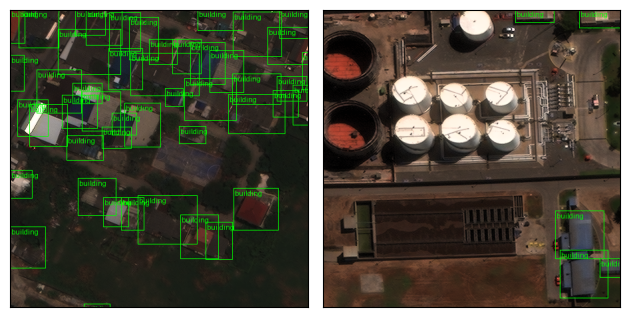

In [11]:
from dl_toolbox.utils import show_detections

for batch in train_dataloader:
    show_detections(batch['image'], batch['target'], class_list=[label("building", (0, 255, 0), {73})])
    break

In [12]:
# Freeze params here if needed
    
#for param in model.feature_extractor.parameters():
#    param.requires_grad = False
strides=[4, 8, 16, 32]
feature_maps_sizes = [(448//s,448//s) for s in strides]
anchors, anchor_sizes = get_all_anchors_bb_sizes(
    fm_sizes=feature_maps_sizes, # 640/16 * [4,2,1,0.5]
    fm_strides=strides,
    bb_sizes=[128, 256, 512]
)

model = ViTDet(num_classes=1, out_channels=256)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#dev = torch.device("cpu")
model.to(dev)
eval_losses = LossEvaluator(
    num_classes=1
)

train_params = list(filter(lambda p: p[1].requires_grad, model.named_parameters()))
nb_train = sum([int(torch.numel(p[1])) for p in train_params])
nb_tot = sum([int(torch.numel(p)) for p in model.parameters()])
print(f"Training {nb_train} params out of {nb_tot}")

#optimizer = torch.optim.SGD(
#    params=[p[1] for p in train_params],
#    lr=0.005,
#    momentum=0.9,
#    weight_decay=0.0005
#)

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=1e-3,
    betas=(0.9,0.999),
    weight_decay=5e-2,
    eps=1e-8,
)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_dataloader),
    epochs=100)
#lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#    optimizer=optimizer,
#    start_factor=1.,
#    end_factor=0.1,
#    total_iters=20
#)

Training 10758498 params out of 10758498


### Training

In [13]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()

start_epoch = 0
for epoch in range(start_epoch, 100):
    time_ep = time.time()
    
    train_loss = 0
    train_cls_loss = 0
    train_reg_loss = 0
    train_cen_loss = 0
    model.train()
    for batch in tqdm(train_dataloader, total=len(train_dataloader)):
        image = batch["image"].to(dev)               
        optimizer.zero_grad()
        cls_logits, bbox_reg, centerness = model(image)
        cls_tgts, reg_tgts = associate_targets_to_anchors(
            batch['target'],
            anchors,
            anchor_sizes
        ) # BxNumAnchors, BxNumAnchorsx4    
        losses = eval_losses(
            cls_logits,
            bbox_reg,
            centerness,
            cls_tgts.to(dev),
            reg_tgts.to(dev)
        )
        loss = losses['combined_loss']
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss += loss.detach().item()
        train_cls_loss += losses["cls_loss"].detach().item()
        train_reg_loss += losses["reg_loss"].detach().item()
        train_cen_loss += losses["centerness_loss"].detach().item()
    train_loss /= len(train_dataloader)
    train_cls_loss /= len(train_dataloader)
    train_reg_loss /= len(train_dataloader)
    train_cen_loss /= len(train_dataloader)
    print(f"{epoch = }")
    print(f"lr = {lr_scheduler.get_last_lr()[0]}"),
    print(f"{train_loss = }")
    print(f"{train_cls_loss = }")
    print(f"{train_reg_loss = }")
    print(f"{train_cen_loss = }")
    
    valid_loss = 0
    valid_cls_loss = 0
    valid_reg_loss = 0
    valid_cen_loss = 0
    model.eval()
    with torch.no_grad():
        map_metric = MeanAveragePrecision(
            box_format='xywh', # make sure your dataset outputs target in xywh format
            backend='faster_coco_eval'
        )
        for batch in tqdm(val_dataloader, total=len(val_dataloader)):
            cls_tgts, reg_tgts = associate_targets_to_anchors(
                batch['target'],
                anchors,
                anchor_sizes
            )
            image = batch["image"].to(dev)
            cls_logits, bbox_reg, centerness = model(image)
            losses = eval_losses(
                cls_logits,
                bbox_reg,
                centerness,
                cls_tgts.to(dev),
                reg_tgts.to(dev)
            )
            loss = losses['combined_loss']
            valid_loss += loss.detach().item()
            valid_cls_loss += losses["cls_loss"].detach().item()
            valid_reg_loss += losses["reg_loss"].detach().item()
            valid_cen_loss += losses["centerness_loss"].detach().item()
            b,c,h,w = image.shape
            preds = post_process_batch(
                cls_logits.to("cpu"),
                bbox_reg.to("cpu"),
                centerness.to("cpu"),
                (h,w)
            )
            map_metric.update(preds, batch['target'])
        valid_loss /= len(val_dataloader)
        valid_cls_loss /= len(val_dataloader)
        valid_reg_loss /= len(val_dataloader)
        valid_cen_loss /= len(val_dataloader)
        mapmetrics = map_metric.compute()
        print(f"{epoch = }")
        print(f"{valid_loss = }")
        print(f"{valid_cls_loss = }")
        print(f"{valid_reg_loss = }")
        print(f"{valid_cen_loss = }")
        print(pformat(mapmetrics))
        map_metric.reset()
    
    time_ep = time.time() - time_ep

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.96it/s]


epoch = 0
lr = 4.263124248945712e-05
train_loss = 2.8940435453504323
train_cls_loss = 1.767603698298335
train_reg_loss = 0.6881284093856812
train_cen_loss = 0.43831142485141755


 52%|█████████████████████████████████████████████████████████████▏                                                        | 276/532 [00:25<00:23, 10.94it/s]


KeyboardInterrupt: 